In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
import warnings
warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

import tensorflow as tf
from tensorflow import keras

print('Num GPU Available:', len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

Num GPU Available: 1


True

In [2]:
import cv2

def gathering(path):
    images = []
    labels = []    

    for r, d, f in os.walk(path):
        for file in f:
            if ".jpeg" or ".jpg" in file:
                imagePath = os.path.join(r, file)
                image = cv2.imread(imagePath)
                image = cv2.resize(image, (75,100))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image)
                label = imagePath.split(os.path.sep)[-2]
                labels.append(label)

                
    return np.array(images), np.array(labels)

In [3]:
# create train, val, test paths
import os
base_dir = 'Datasets\\aug_skin'
train_dir = os.path.join(base_dir, 'augment')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [4]:
x_train, y_train = gathering(train_dir)
x_test, y_test = gathering(test_dir)
x_val, y_val = gathering(validation_dir)

In [5]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [6]:
# label encoder implementation in each train & test label
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_val = lb.fit_transform(y_val)
y_test = lb.fit_transform(y_test)

ValueError: numpy.ufunc size changed, may indicate binary incompatibility. Expected 232 from C header, got 216 from PyObject

In [ ]:
pip uninstall numpy

In [154]:
x_test.shape

(442, 75, 100, 3)

In [146]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [157]:
# build a simple model
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, GlobalMaxPool2D, GlobalAvgPool2D, Flatten
from tensorflow.keras.layers import Dropout, SpatialDropout2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax


model = Sequential()
model.add(InputLayer(input_shape=[75, 100, 3]))

model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(SpatialDropout2D(rate=0.25))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Flatten())

# fully connected
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 75, 100, 16)       448       
                                                                 
 batch_normalization_9 (Batc  (None, 75, 100, 16)      64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 38, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 38, 50, 32)        4640      
                                                                 
 batch_normalization_10 (Bat  (None, 38, 50, 32)       128       
 chNormalization)                                                
                                                      

In [158]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [159]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 64) ,epochs = 100 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/100
92/92 [==============================] - 11s 115ms/step - loss: 0.8255 - accuracy: 0.5682 - val_loss: 0.7258 - val_accuracy: 0.3857 - lr: 1.0000e-05
Epoch 2/100
92/92 [==============================] - 11s 117ms/step - loss: 0.7192 - accuracy: 0.6196 - val_loss: 0.6694 - val_accuracy: 0.6343 - lr: 1.0000e-05
Epoch 3/100
92/92 [==============================] - 11s 116ms/step - loss: 0.6687 - accuracy: 0.6407 - val_loss: 0.6239 - val_accuracy: 0.6657 - lr: 1.0000e-05
Epoch 4/100
92/92 [==============================] - 11s 118ms/step - loss: 0.6317 - accuracy: 0.6561 - val_loss: 0.6021 - val_accuracy: 0.6400 - lr: 1.0000e-05
Epoch 5/100
92/92 [==============================] - ETA: 0s - loss: 0.6269 - accuracy: 0.6540
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
92/92 [==============================] - 11s 121ms/step - loss: 0.6269 - accuracy: 0.6540 - val_loss: 0.5940 - val_accuracy: 0.6514 - lr: 1.0000e-05
Epoch 6/100
92/92 [================

Epoch 50/100
92/92 [==============================] - 15s 160ms/step - loss: 0.5543 - accuracy: 0.7054 - val_loss: 0.5641 - val_accuracy: 0.7229 - lr: 1.0000e-06
Epoch 51/100
92/92 [==============================] - 14s 154ms/step - loss: 0.5530 - accuracy: 0.7041 - val_loss: 0.5782 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 52/100
92/92 [==============================] - 14s 149ms/step - loss: 0.5536 - accuracy: 0.7049 - val_loss: 0.5706 - val_accuracy: 0.7057 - lr: 1.0000e-06
Epoch 53/100
92/92 [==============================] - 15s 159ms/step - loss: 0.5549 - accuracy: 0.7080 - val_loss: 0.5884 - val_accuracy: 0.6857 - lr: 1.0000e-06
Epoch 54/100
92/92 [==============================] - 15s 160ms/step - loss: 0.5578 - accuracy: 0.7046 - val_loss: 0.5746 - val_accuracy: 0.7143 - lr: 1.0000e-06
Epoch 55/100
92/92 [==============================] - 14s 153ms/step - loss: 0.5538 - accuracy: 0.7088 - val_loss: 0.5794 - val_accuracy: 0.7143 - lr: 1.0000e-06
Epoch 56/100
92/92 [========

In [160]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

14/14 [==============================] - 0s 8ms/step - loss: 0.5345 - accuracy: 0.7262
Loss of the model is -  0.5345062017440796
14/14 [==============================] - 0s 7ms/step - loss: 0.5345 - accuracy: 0.7262
Accuracy of the model is -  72.6244330406189 %


Text(0.5, 1.0, 'Accuracy Evolution')

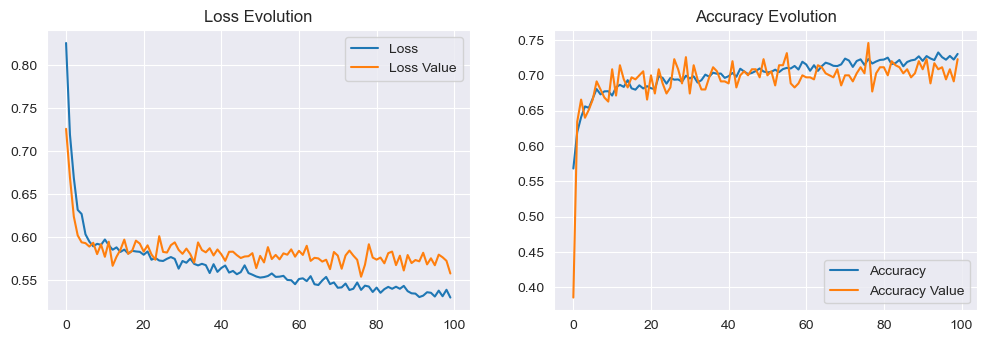

In [161]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Loss Value')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Accuracy Value')
plt.legend()
plt.title('Accuracy Evolution')

In [163]:
import numpy as np
import pandas as pd
# classification report
from sklearn.metrics import classification_report
# model.load_weights(best_model_path)

pred = model.predict(x_test)
# labels = np.argmax(pred, axis = 1)
labels = (pred > 0.5).astype(np.int)

print('Classification Report: ')
# print(classification_report(test_iterator.classes, labels, target_names = ['Pneumonia \'0\'','Normal \'1\'']))
print(classification_report(y_test, labels, target_names = ['Benign \'0\'','Malignant \'1\'']))

14/14 [==============================] - 0s 6ms/step
Classification Report: 
               precision    recall  f1-score   support

   Benign '0'       0.73      0.89      0.80       273
Malignant '1'       0.72      0.47      0.57       169

     accuracy                           0.73       442
    macro avg       0.72      0.68      0.68       442
 weighted avg       0.72      0.73      0.71       442



In [164]:
from sklearn.metrics import confusion_matrix
confma = confusion_matrix(y_test, labels)
confma

array([[242,  31],
       [ 90,  79]], dtype=int64)

In [165]:
import pandas as pd
confma = pd.DataFrame(confma , index = ['0','1'] , columns = ['0','1'])
confma

,0,1
0,242,31
1,90,79


<AxesSubplot:>

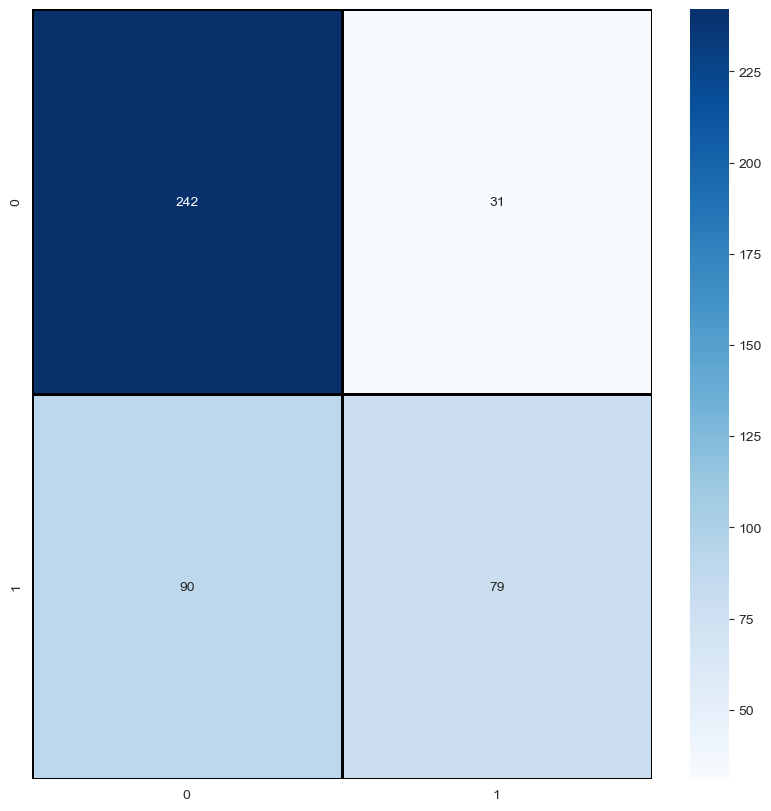

In [166]:
import seaborn as sns
plt.figure(figsize = (10,10))
sns.heatmap(confma,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [167]:
model.save('CNN_skin_aug.h5')

In [1]:
modelEfficientNetB3 = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(75, 100, 3),
    pooling='avg',
    classifier_activation='sigmoid'
)

NameError: name 'tf' is not defined

In [185]:
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential


In [186]:
x=modelEfficientNetB3.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=.3, seed=1234)(x)        
output=Dense(1, activation='sigmoid')(x)
model2=Model(inputs=modelEfficientNetB3.input, outputs=output)
model2.compile(Adam(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])

In [187]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 rescaling_4 (Rescaling)        (None, 75, 100, 3)   0           ['input_7[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 75, 100, 3)  7           ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

 block2a_expand_activation (Act  (None, 38, 50, 144)  0          ['block2a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 39, 51, 144)  0          ['block2a_expand_activation[0][0]
 g2D)                                                            ']                               
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 19, 25, 144)  1296       ['block2a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 19, 25, 144)  576        ['block2a_dwconv[0][0]']         
 )        

 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 19, 25, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_s

                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_se_excite (Multiply)   (None, 10, 13, 288)  0           ['block3b_activation[0][0]',     
                                                                  'block3b_se_expand[0][0]']      
                                                                                                  
 block3b_p

                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 5, 7, 288)    0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 5, 7, 96)     27648       ['block4a_se_excite[0][0]']      
                                                                                                  
 block4a_p

 block4c_project_bn (BatchNorma  (None, 5, 7, 96)    384         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 5, 7, 96)     0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 5, 7, 96)     0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, 5, 7, 576)    55296       ['block4c_add[0][0]']            
                                                                                                  
 block4d_e

 block4e_add (Add)              (None, 5, 7, 96)     0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 5, 7, 576)    55296       ['block4e_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 5, 7, 576)   2304        ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 5, 7, 576)   0           ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 5, 7, 816)   20400       ['block5c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 5, 7, 816)   3264        ['block5c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5c_activation (Activation  (None, 5, 7, 816)   0           ['block5c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5c_s

 )                                                                                                
                                                                                                  
 block5e_activation (Activation  (None, 5, 7, 816)   0           ['block5e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 816)         0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_se_reshape (Reshape)   (None, 1, 1, 816)    0           ['block5e_se_squeeze[0][0]']     
                                                                                                  
 block5e_s

                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 3, 4, 1392)   0           ['block6b_activation[0][0]',     
                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_p

 block6d_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, 3, 4, 1392)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 3, 4, 232)    322944      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 3, 4, 232)   928         ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_d

 block6f_project_conv (Conv2D)  (None, 3, 4, 232)    322944      ['block6f_se_excite[0][0]']      
                                                                                                  
 block6f_project_bn (BatchNorma  (None, 3, 4, 232)   928         ['block6f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6f_drop (Dropout)         (None, 3, 4, 232)    0           ['block6f_project_bn[0][0]']     
                                                                                                  
 block6f_add (Add)              (None, 3, 4, 232)    0           ['block6f_drop[0][0]',           
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block7a_e

 top_conv (Conv2D)              (None, 3, 4, 1536)   589824      ['block7b_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 3, 4, 1536)   6144        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 3, 4, 1536)   0           ['top_bn[0][0]']                 
                                                                                                  
 avg_pool (GlobalAveragePooling  (None, 1536)        0           ['top_activation[0][0]']         
 2D)                                                                                              
                                                                                                  
 batch_normalization_15 (BatchN  (None, 1536)        6144        ['avg_pool[0][0]']               
 ormalizat

In [188]:
history2 = model2.fit(datagen.flow(x_train,y_train, batch_size = 64) ,epochs = 40 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/40
92/92 [==============================] - 85s 761ms/step - loss: 0.5453 - accuracy: 0.7444 - val_loss: 3.1088 - val_accuracy: 0.6171 - lr: 0.0010
Epoch 2/40
92/92 [==============================] - 118s 1s/step - loss: 0.3771 - accuracy: 0.8209 - val_loss: 66.6745 - val_accuracy: 0.6171 - lr: 0.0010
Epoch 3/40
92/92 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.8704
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
92/92 [==============================] - 138s 2s/step - loss: 0.3048 - accuracy: 0.8704 - val_loss: 0.6745 - val_accuracy: 0.6171 - lr: 0.0010
Epoch 4/40
92/92 [==============================] - 134s 1s/step - loss: 0.1970 - accuracy: 0.9200 - val_loss: 1.1827 - val_accuracy: 0.6171 - lr: 3.0000e-04
Epoch 5/40
92/92 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9469
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
92/92 [==============================] - 132s 1s

In [189]:
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%")

14/14 [==============================] - 1s 80ms/step - loss: 0.6313 - accuracy: 0.8371
Loss of the model is -  0.6312703490257263
14/14 [==============================] - 1s 81ms/step - loss: 0.6313 - accuracy: 0.8371
Accuracy of the model is -  83.7104082107544 %


Text(0.5, 1.0, 'Accuracy Evolution')

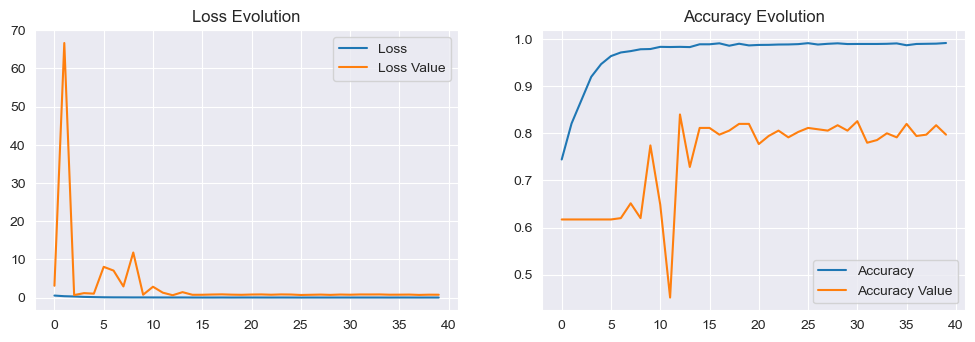

In [192]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='Loss Value')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history2.history['accuracy'], label='Accuracy')
plt.plot(history2.history['val_accuracy'], label='Accuracy Value')
plt.legend()
plt.title('Accuracy Evolution')

In [194]:
import numpy as np
import pandas as pd
# classification report
from sklearn.metrics import classification_report
# model.load_weights(best_model_path)

pred2 = model2.predict(x_test)
# labels = np.argmax(pred, axis = 1)
labels2 = (pred2 > 0.5).astype(np.int)

print('Classification Report: ')
# print(classification_report(test_iterator.classes, labels, target_names = ['Pneumonia \'0\'','Normal \'1\'']))
print(classification_report(y_test, labels2, target_names = ['Benign \'0\'','Malignant \'1\'']))

14/14 [==============================] - 1s 71ms/step
Classification Report: 
               precision    recall  f1-score   support

   Benign '0'       0.84      0.90      0.87       273
Malignant '1'       0.83      0.73      0.77       169

     accuracy                           0.84       442
    macro avg       0.83      0.82      0.82       442
 weighted avg       0.84      0.84      0.83       442



In [196]:
from sklearn.metrics import confusion_matrix
confma2 = confusion_matrix(y_test, labels2)
confma2

array([[247,  26],
       [ 46, 123]], dtype=int64)

In [197]:
import pandas as pd
confma2 = pd.DataFrame(confma2 , index = ['0','1'] , columns = ['0','1'])
confma2

,0,1
0,247,26
1,46,123


<AxesSubplot:>

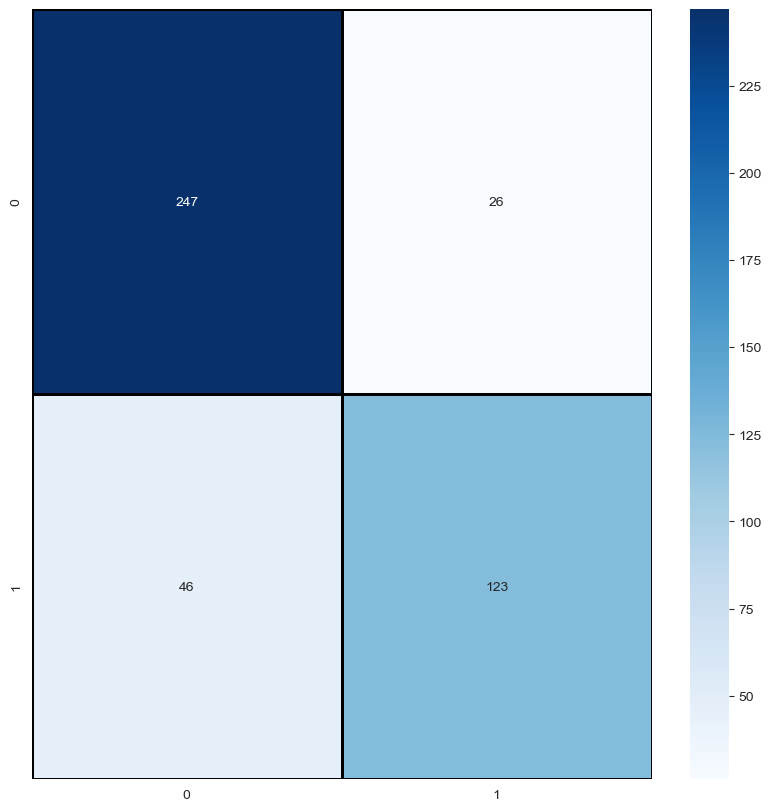

In [198]:
import seaborn as sns
plt.figure(figsize = (10,10))
sns.heatmap(confma2,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [199]:
model.save('EfficientNetB3_skin_aug.h5')